##### **Jon Sedar Personal Project**

### PyMC3 Examples `pymc3_examples`

###### _2019Q4_

# GLM: Robust Regression using a Gaussian Mixture Model for Outlier Classification

`glm-robust-regression-using-a-gmm-for-outlier-classification.ipynb`

Using PyMC3 for Robust Regression with Outlier Detection using a Gaussian Mixture Model. 


**Modelling concept:**
+ These models fits as a mixture of two likelihoods, one for the main data-generating function (a linear model that we care about), and one for outliers.
+ One model marginalizes over the outlier classification and the second does not marginalize and thus gives us a classification of outlier-hood for each datapoint
+ The dataset is tiny and hardcoded into this Notebook. It contains errors in both the x and y, but we will deal here with only errors in y.

**Complementary approaches:**
+ To be compared with the Hogg 2010 Signal vs Noise method [demonstrated in a sister Notebook](https://github.com/jonsedar/pymc3_examples/blob/master/notebooks/glm-robust-regression-using-custom-likelihood-for-outlier-classification.ipynb). 
+ See also a [gist by Dan FM](https://gist.github.com/dfm/5250dd2f17daf60cbe582ceeeb2fd12f) that he published after a quick twitter conversation - his "Hogg improved" model uses this same model structure and cleverly marginalizes over the outlier class but also observes it during sampling using a `pm.Deterministic`
+ See also a [gist by Jun Peng Lao](https://gist.github.com/junpenglao/4d65d1a9bf80e8d371446fadda9deb7a) for his PyMC3 port of the [Stan case study - identifying mixture models](http://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html)



## Contents

+ [Setup](#Setup)
    + [Installation Notes](#Installation-Notes)
    + [Imports](#Imports)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
+ [1. Basic EDA](#1.-Basic-EDA)
+ [2. Basic Feature Engineering](#2.-Basic-Feature-Engineering)
+ [3. Gaussian Mixture Model: Marginalized](#3.-Gaussian-Mixture-Model:-Marginalized)
+ [4. Gaussian Mixture Model: Non-Marginalized](#3.-Gaussian-Mixture-Model:-Non-Marginalized)

# Setup

## Installation Notes

See the project [README](https://github.com/jonsedar/pymc3_examples/blob/master/README.md) for full details. For MVP reproduction, see following notes

##### General:

+ This is a Python 3.6 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3) at time of writing `pymc3=3.7`
+ Developed in 2019Q4 using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a Macbook 2017 1.4GHz i7 Dual Core, 16GB RAM, OSX 10.14.6
+ If runs become unstable or Theano throws weird errors, first try clearing the cache `theano-cache clear` and rerunning the notebook.


##### Package Requirements (shown as a condaenv YAML)

```
$> less conda_env_pymc3_examples.yml

    name: pymc3_examples
    channels:
    - defaults
    - conda-forge
    dependencies:
    - python==3.6.*
    - cython
    - ipython
    - jupyter
    - mkl
    - mkl-service
    - numpy
    - scipy
    - matplotlib
    - pandas
    - scikit-learn
    - seaborn
    - patsy
    - statsmodels
    - tqdm
    - watermark
    - sphinx
    - pytest
    - nose
    - parameterized
    - python-graphviz
    - pip

$> conda env create --file conda_env_pymc3_examples.yml
$> source activate pymc3_examples
$> pip install pymc3==3.7 theano arviz daft
$> jupyter notebook
```

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --style=monokai --ConsoleWidget.font_size=11

## Imports

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt
import arviz as az

# terrible practice to hide package warnings, 
# but doing so for presentation post development
# import warnings
# warnings.filterwarnings('ignore')  

sns.set(style='darkgrid', palette='muted', context='notebook')
plt.rcParams['figure.figsize'] = 16, 4
np.random.seed(0)

%load_ext watermark
%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

2019-12-06 18:10:54 

CPython 3.6.9
IPython 7.8.0

numpy 1.17.2
scipy 1.3.1
matplotlib 3.1.1
pandas 0.25.2
seaborn 0.9.0
pymc3 3.7
theano 1.0.4
arviz 0.5.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : c487a7307800628320424be55b61400f769bf2f5


## Local Functions

In [3]:
# None

## Load Data

We'll use the Hogg 2010 data available at  https://github.com/astroML/astroML/blob/master/astroML/datasets/hogg2010test.py

It's a very small dataset so for convenience, it's hardcoded below

In [4]:
# cut & pasted directly from the fetch_hogg2010test() function
# identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(
                np.array([[1, 201, 592, 61, 9, -0.84],
                          [2, 244, 401, 25, 4, 0.31],
                          [3, 47, 583, 38, 11, 0.64],
                          [4, 287, 402, 15, 7, -0.27],
                          [5, 203, 495, 21, 5, -0.33],
                          [6, 58, 173, 15, 9, 0.67],
                          [7, 210, 479, 27, 4, -0.02],
                          [8, 202, 504, 14, 4, -0.05],
                          [9, 198, 510, 30, 11, -0.84],
                          [10, 158, 416, 16, 7, -0.69],
                          [11, 165, 393, 14, 5, 0.30],
                          [12, 201, 442, 25, 5, -0.46],
                          [13, 157, 317, 52, 5, -0.03],
                          [14, 131, 311, 16, 6, 0.50],
                          [15, 166, 400, 34, 6, 0.73],
                          [16, 160, 337, 31, 5, -0.52],
                          [17, 186, 423, 42, 9, 0.90],
                          [18, 125, 334, 26, 8, 0.40],
                          [19, 218, 533, 16, 6, -0.78],
                          [20, 146, 344, 22, 5, -0.56]]),
                columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

dfhogg['id'] = dfhogg['id'].apply(lambda x: 'p{}'.format(int(x)))
dfhogg.set_index('id', inplace=True)
dfhogg.head()

,x,y,sigma_y,sigma_x,rho_xy
id,,,,,
p1,201.0,592.0,61.0,9.0,-0.84
p2,244.0,401.0,25.0,4.0,0.31
p3,47.0,583.0,38.0,11.0,0.64
p4,287.0,402.0,15.0,7.0,-0.27
p5,203.0,495.0,21.0,5.0,-0.33


---

# 1. Basic EDA

##### Exploratory Data Analysis

Note:
+ this is very rudimentary so we can quickly get to the `pymc3`
+ the dataset contains errors in both the x and y, but we will deal here with only errors in y.
+ see the [Hogg 2010 paper](https://arxiv.org/pdf/1008.4686.pdf) for more detail

/Users/jon/anaconda/envs/pymc3_examples/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


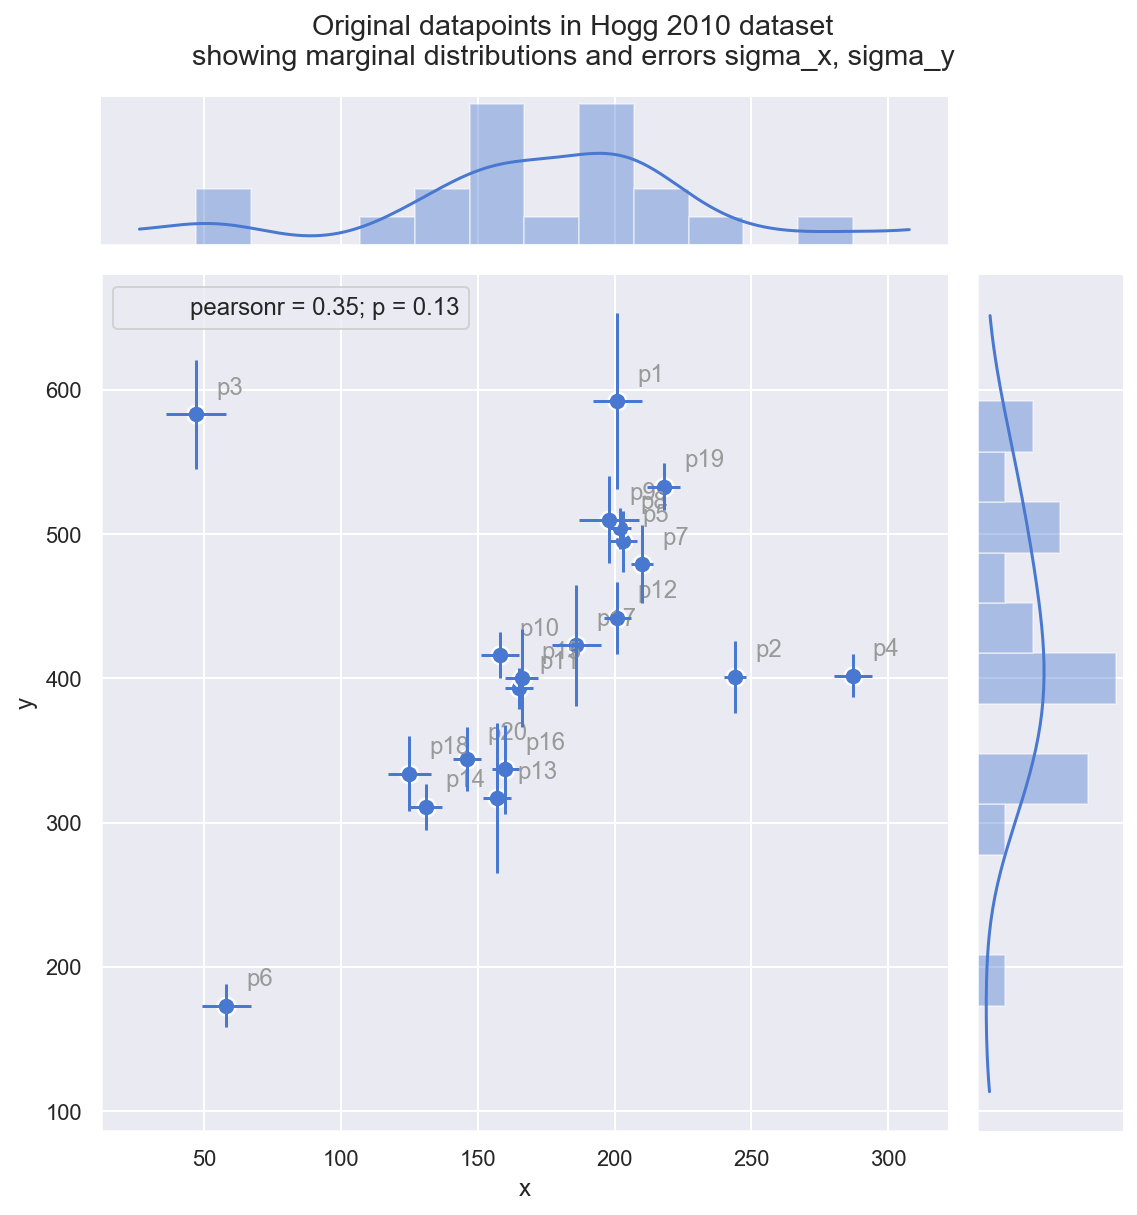

In [5]:
gd = sns.jointplot(x='x', y='y', data=dfhogg, kind='scatter', height=8,
        marginal_kws={'bins':12, 'kde':True, 'kde_kws':{'cut':1}},
        joint_kws={'edgecolor':'w', 'linewidth':1.2, 's':80})

_ = gd.ax_joint.errorbar('x', 'y', 'sigma_y', 'sigma_x', fmt='none', 
                            ecolor='#4878d0', data=dfhogg, zorder=10)
for idx, r in dfhogg.iterrows():
    _ = gd.ax_joint.annotate(s=idx, xy=(r['x'], r['y']), xycoords='data', 
                             xytext=(10, 10), textcoords='offset points', 
                             color='#999999', zorder=1)
    
_ = gd.annotate(stats.pearsonr, loc="upper left", fontsize=12)
_ = gd.fig.suptitle(('Original datapoints in Hogg 2010 dataset\n' + 
        'showing marginal distributions and errors sigma_x, sigma_y'), y=1.05)

**Observe**:  

+ Even judging just by eye, you can see these observations mostly fall on / around a straight line with positive gradient
+ It looks like a few of the datapoints may be outliers from such a line
+ Measurement error (independently on x and y) varies across the observations

---

# 2. Basic Feature Engineering

Note: ordinarily I might run through more formalised steps to split into Train and Test sets (to later help evaluate model fit), but here I'll just fit the model to the full dataset and stop at inference

## 2.1 Transform and standardize dataset

It's common practice to standardize the input values to a linear model, because this leads to coefficients sitting in the same range and beng more directly comparable. e.g. Gelman notes this in a 2007 paper: http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf.

So, following Gelman's paper above, we'll divide by 2 s.d. here
+ since this model is very simple, we just standardize directly, rather than using e.g. a scikit-learn FunctionTransformer
+ ignoring `rho_xy` for now

**Additional note** on scaling the output feature `y` and measurement error `sigma_y`:
+ This is unconventional - typically you wouldn't scale an output feature
+ However, in the Hogg model we fit a custom two-part likelihood function of Normals which encourages a globally minimised log-loss by allowing outliers to fit to their own Normal distribution. This outlier distribution is specified using a stdev stated as an offset `sigma_y_out` from `sigma_y`
+ This offset value has the effect of requiring `sigma_y` to be restated in the same scale as the stdev of `y`

### Standardize (mean center and divide by 2 sd)

In [6]:
dfhoggs = ((dfhogg[['x', 'y']] - dfhogg[['x', 'y']].mean(0)) / 
           (2 * dfhogg[['x', 'y']].std(0)))
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / ( 2 * dfhogg['x'].std())
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / ( 2 * dfhogg['y'].std())

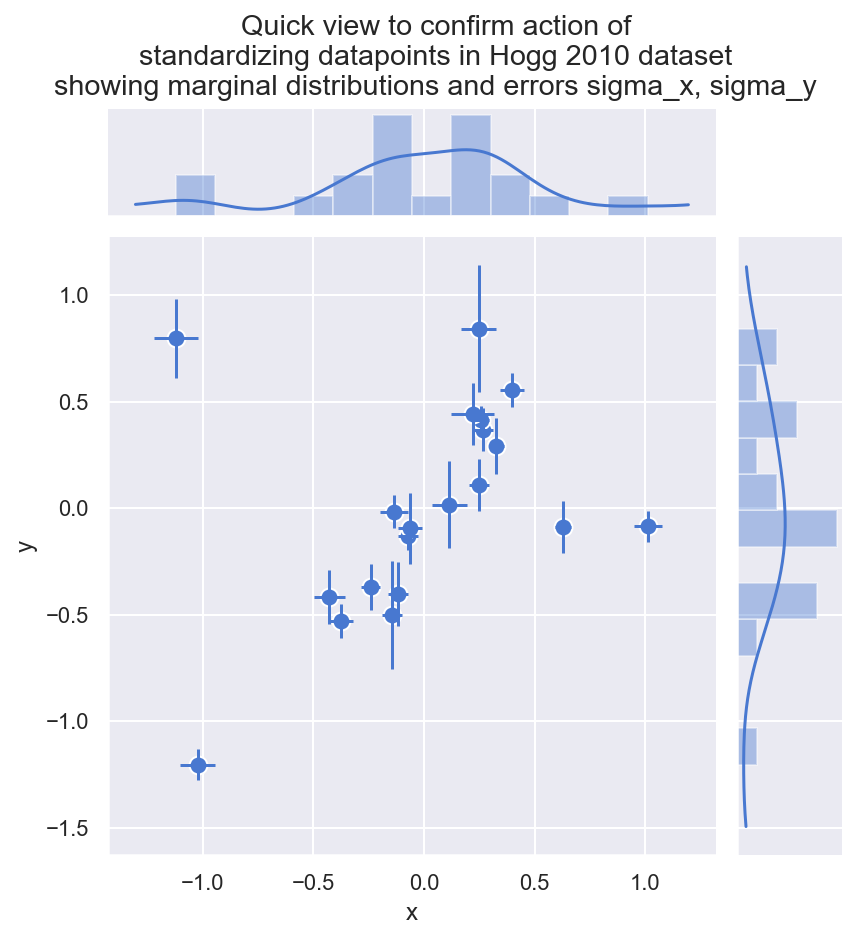

In [7]:
gd = sns.jointplot(x='x', y='y', data=dfhoggs, kind='scatter', height=6,
        marginal_kws={'bins':12, 'kde':True, 'kde_kws':{'cut':1}},
        joint_kws={'edgecolor':'w', 'linewidth':1, 's':80})
_ = gd.ax_joint.errorbar('x', 'y', 'sigma_y', 'sigma_x', fmt='none', 
                            ecolor='#4878d0', data=dfhoggs)
_ = gd.fig.suptitle(('Quick view to confirm action of\n' +
        'standardizing datapoints in Hogg 2010 dataset\n' + 
        'showing marginal distributions and errors sigma_x, sigma_y'), y=1.08)

---

# 3. Gaussian Mixture Model: Marginalized

Before we non-marginalize, let's marginalize over $\eta$: the model ought to run faster and be simpler to specify

## 3.1 Specify Model

Priors for 'inliers' (which use our theoretical linear relationship in the data $x_{j}$, in this case `1 + x`

\begin{align}
\mu_{k1} =& \beta^{T} \vec{x}_{i}, & (\beta = \{1, \beta_{j \in x_{j}}\} ) \\
\sigma_{k1} = & \text{`sigma_y`}\\
\end{align}

Priors for 'outliers' (which use another distribution, for which we don't have any particular knowledge or theory of a parameteric form)

\begin{align}
\mu_{k2} \sim &  \mathcal{N}(0, 10)\\
\sigma_{k2} \sim & \text{HalfCauchy}(10)\\
\end{align}

Priors for mixture components and overall likelihood evaluation:

\begin{align}
\vec{\alpha} &\sim [1]^K\\
\vec{w} &\sim \text{Dir}(\vec{\alpha})\\
\\
\mathcal{f}(x | \vec{w}, \mu_{k}, \sigma_{k}) &= \sum^{K}_{k=1}w_{k}\mathcal{N}(x | \mu_{k}, \sigma_{k})\\
\end{align}

... where:
+ $k \in K$ total Gaussian mixtures (here $K = 2$: one for inliers, one for outliers)


In [8]:
n = len(dfhoggs)
eta = ['inlier', 'outlier']
K = len(eta)

In [9]:
# raise ValueError('pause')

##### Non-exchangable random priors

In [10]:
with pm.Model() as mdl_mix_marg1:
       
    tsv_y = pm.Data('tsv_y', dfhoggs['y'].values)          # (n, )
    
    q = np.quantile(dfhoggs['y'], [0.25, 0.75])
    mu0 = pm.Normal('mu0', mu=-1, sigma=1, testval=q[0])  # (1, )
    mu1 = pm.Normal('mu1', mu=1, sigma=1, testval=q[1])   # (1, )

    s = pm.HalfCauchy('sigma', beta=10, shape=(K, ))       # (K, )

    # break symmetry
    potential = pm.Potential('order', 
                             tt.switch(mu1 - mu0 < 0, -1e50, 0)) 

    # prior on mixture weights
    w0 = pm.Dirichlet('w0', a=np.ones(K), 
                      testval=np.ones(K)/K, shape=(K, ))   # (K, )

    like = pm.NormalMixture('like', w=w0, mu=[mu0, mu1], 
                            sigma=s, observed=tsv_y)       # (n,K)


In [11]:
# with mdl_mix_marg1:
#     trc_mix_marg1 = pm.sample(tune=2000, draws=500, chains=6, cores=3, 
#                     init='adapt_diag', target_accept=0.85)
    
# _ = az.plot_forest(trc_mix_marg1, var_names=['mu0', 'mu1'])

In [12]:
raise ValueError('pause')

ValueError: pause

##### first working version!

In [128]:
with pm.Model() as mdl_mix_marg:
    
    # input data as Theano shared vars
    tsv_x = pm.Data('tsv_x', dfhoggs['x'].values)                      # (n, )
    tsv_y = pm.Data('tsv_y', dfhoggs['y'].values)                      # (n, )
    tsv_sigma_y = pm.Data('tsv_sigma_y', dfhoggs['sigma_y'].values)    # (n, )
    
    # prior on mixture weights
    w0 = pm.Dirichlet('w0', a=np.ones(K), testval=[1.1, .9], shape=(K, ))
   
    # weakly informative Normal priors (L2 ridge reg) for inlier model
    b0 = pm.Normal('b0_intercept', mu=0, sigma=10, testval=0)
    b1 = pm.Normal('b1_slope', mu=0, sigma=10, testval=1)

    # create inlier linear model
    mu_in = b0 + b1 * tsv_x                                            # (n, )

    # create outlier linear model (note syntax to allow observation)
    mu_out = pm.Normal('mu_out', mu=0, sd=10, testval=0.1) * tt.ones_like(tsv_x)                           # (n, )
    
    # additional variance for outlier errors
    sigma_y_out = pm.HalfCauchy('sigma_y_out', beta=10, testval=0.1)   # (1, )    
    
    # stack params to go into NormalMixture likelihood
    mu = tt.stack([mu_in, mu_out], axis=1)                             # (n,K)
    sigma = tt.stack([tsv_sigma_y, tsv_sigma_y+sigma_y_out], axis=1)   # (n,K)

    like = pm.NormalMixture('like', w0, mu=mu, sigma=sigma, observed=tsv_y)  # (n,K)


Issues to improve:
    
+ Stacking is less elegant than vectorised
+ I don't like relying on pm.NormalMixture, would like to generalise to pm.Mixture
    

In [129]:
#     # set mixture components as distributions ?
#     mu_in = pm.Normal.dist(mu=b0+b1*tsv_x, sigma=tsv_sigma_y)          # (n, )
#     mu_out = pm.Normal.dist(mu=0, sigma=tsv_sigma_y+sigma_y_out)       # (n, )     
#     like = pm.Mixture('like', w=w0, comp_dists=[mu_in, mu_out], observed=tsv_y)  # (n,K)

## 3.2 Fit Model

### 3.2.1 Sample Posterior

Note: use lots of chains to help detect poor sampling and class switching

In [130]:
with mdl_mix_marg:
    trc_mix_marg = pm.sample(tune=2000, draws=500, chains=6, cores=3, 
                    init='jitter+adapt_diag', target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 3 jobs)
NUTS: [sigma_y_out, mu_out, b1_slope, b0_intercept, w0]
Sampling 6 chains: 100%|██████████| 9000/9000 [00:20<00:00, 443.42draws/s]
The acceptance probability does not match the target. It is 0.9787838303933417, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.815380699330404, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.614653337464402, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


### 3.2.2 View Diagnostics

##### Traceplot

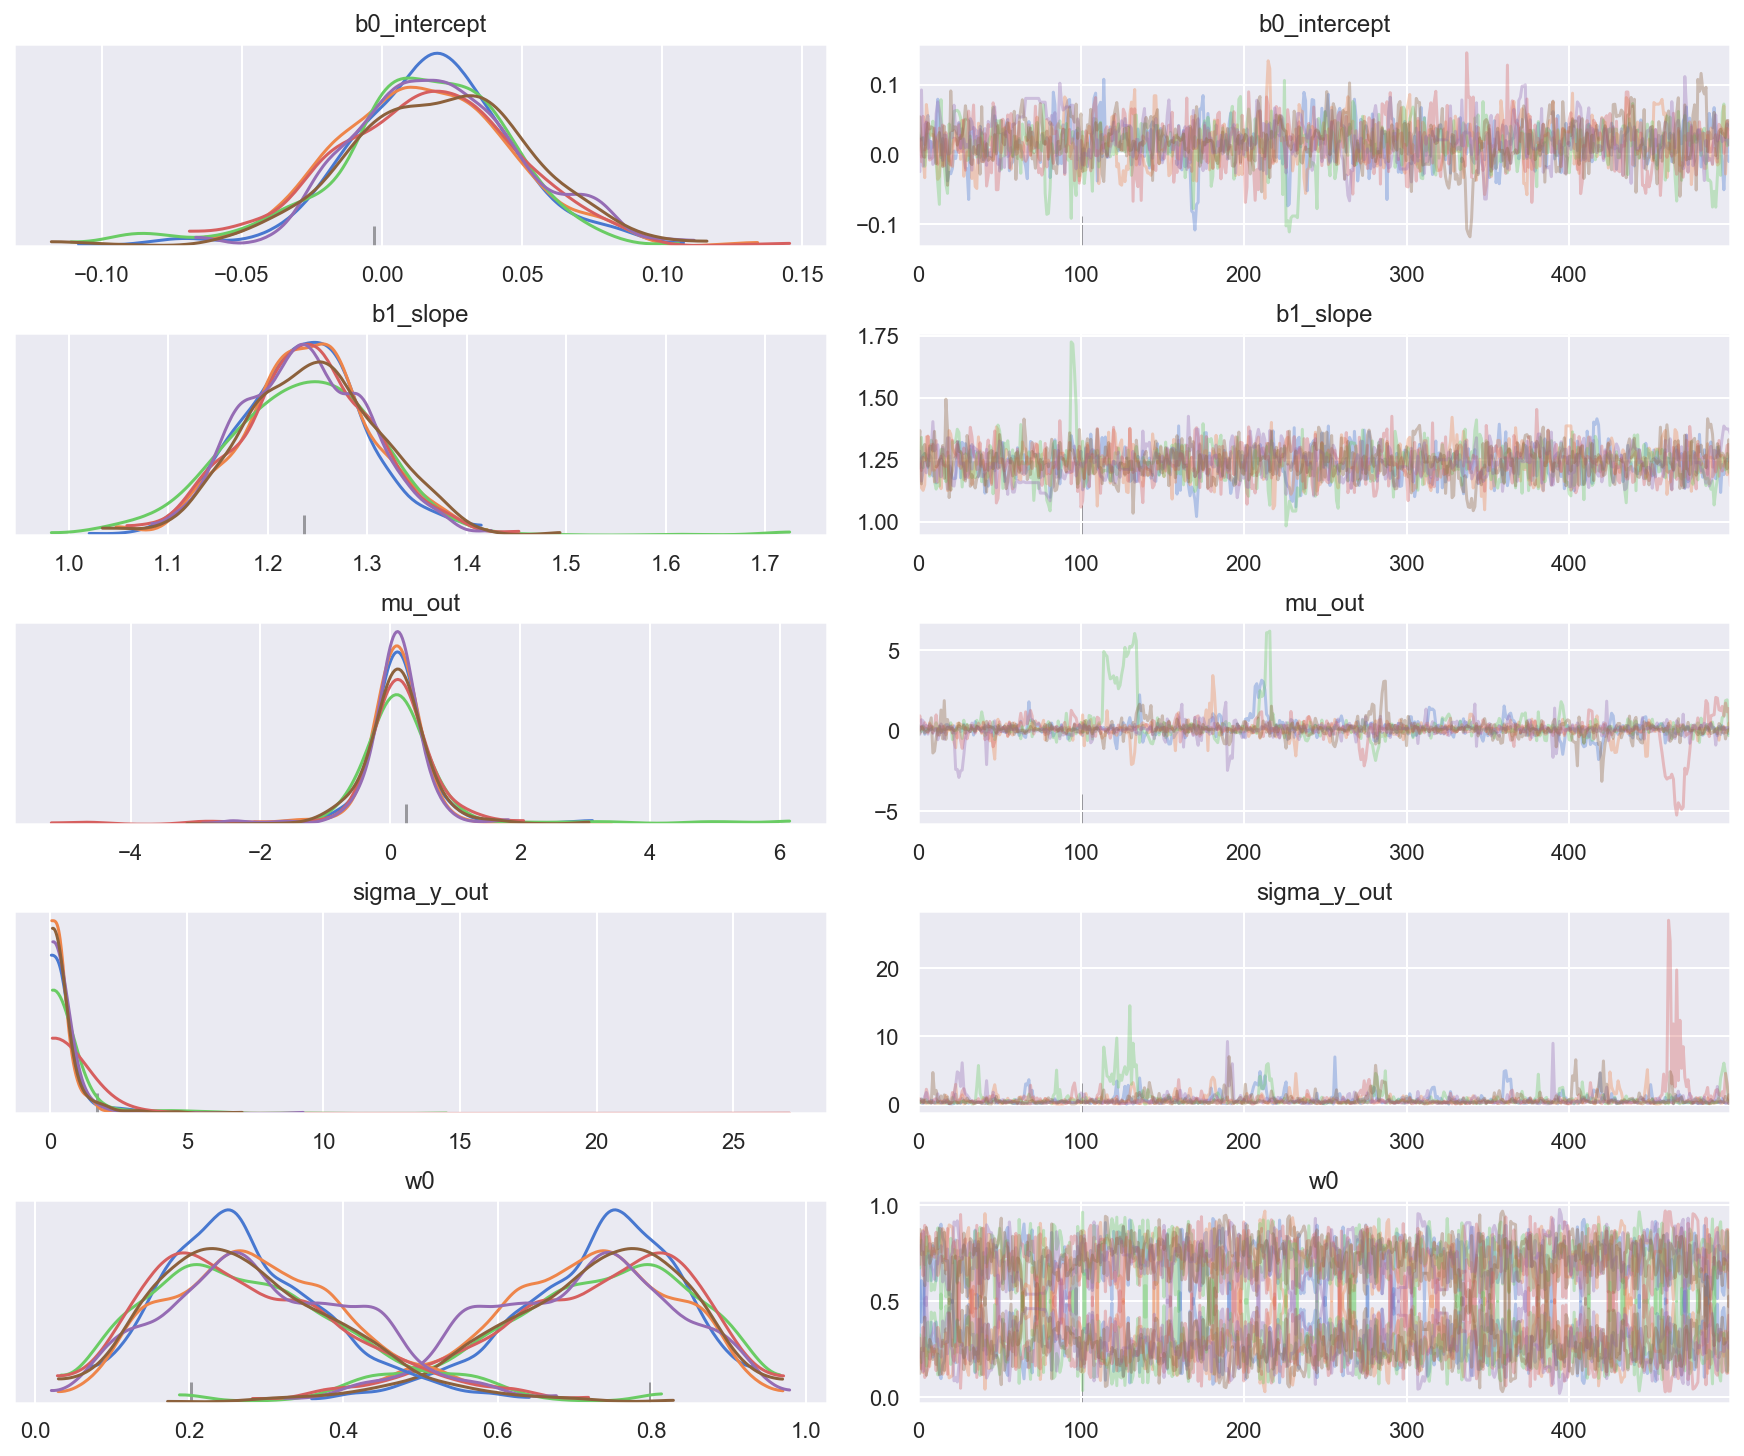

In [134]:
rvs = ['b0_intercept', 'b1_slope', 'mu_out', 'sigma_y_out', 'w0']
_ = az.plot_trace(trc_mix_marg, var_names=rvs, combined=False, compact=True)

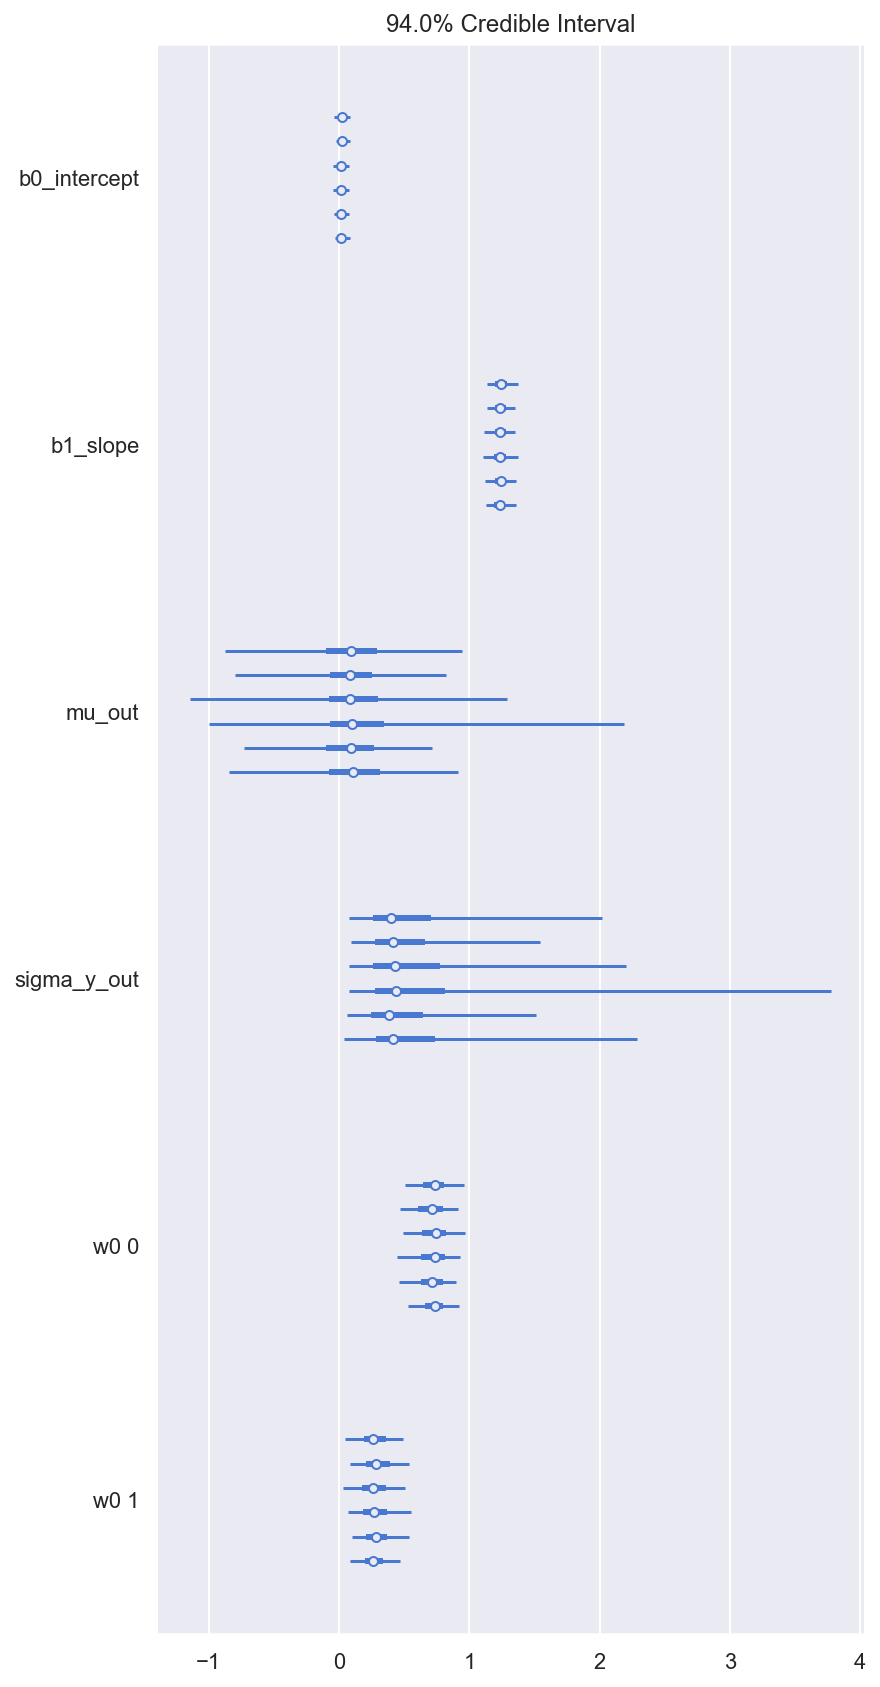

In [135]:
_ = az.plot_forest(trc_mix_marg, var_names=rvs)

In [136]:
# _ = plt.plot(trc_mix_marg.get_values('w0'))

**Observe:**
    
+ 

##### Simple trace summary inc rhat

In [137]:
pm.summary(trc_mix_marg, var_names=rvs)

/Users/jon/anaconda/envs/pymc3_examples/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b0_intercept,0.016851,0.031226,0.000985,-0.038232,0.082056,1097.557045,1.003407
b1_slope,1.238162,0.066373,0.001944,1.121480,1.373825,1186.602900,1.000619
mu_out,0.121649,0.682310,0.040605,-0.998911,1.190115,288.366562,1.012282
sigma_y_out,0.730574,1.229368,0.060803,0.037905,2.371869,396.433294,1.004519
w0__0,0.714787,0.126118,0.004037,0.464423,0.934316,995.799482,1.001683
w0__1,0.285213,0.126118,0.004037,0.065684,0.535577,995.799482,1.001683


##### View posterior joint distribution (since the model has only 2 coeffs, we can easily view this as a 2D joint distribution)

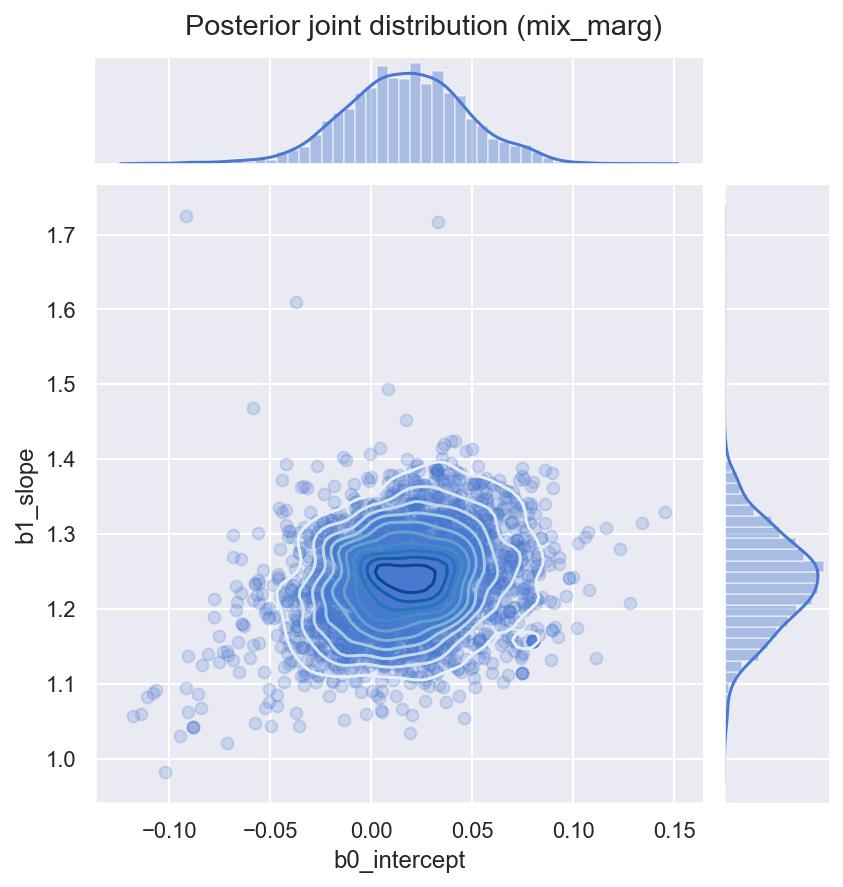

In [138]:
df_trc_mix_marg = pm.trace_to_dataframe(trc_mix_marg)
gd = sns.jointplot(x='b0_intercept', y='b1_slope', data=df_trc_mix_marg, 
            height=6, marginal_kws={'kde':True, 'kde_kws':{'cut':1}},
            joint_kws={'alpha':0.2})
gd.plot_joint(sns.kdeplot, zorder=2, cmap='Blues', n_levels=12)
_ = gd.fig.suptitle('Posterior joint distribution (mix_marg)', y=1.02)

##### View posterior distributions of each Normal

In [ ]:
# df_trc_mix_marg = pm.trace_to_dataframe(trc_mix_marg)
# gd = sns.jointplot(x='mu__0', y='mu__1', data=df_trc_mix_marg, height=6, 
#                    marginal_kws={'kde':True, 'kde_kws':{'cut':1}},
#                    joint_kws={'alpha':0.2})
# gd.plot_joint(sns.kdeplot, zorder=0, cmap="Blues", n_levels=12)
# _ = gd.fig.suptitle('Posterior joint distribution (mu0, mu1)', y=1.02)

---

# 4. Gaussian Mixture Model: Non-Marginalized

## 4.1 Specify Model

Blurb WIP

\begin{align}
\mu_{k} &\sim \mathcal{N}(0, 1)\\
\sigma_{k} &\sim \text{HalfCauchy}(10)\\
\\
\vec{\alpha} &\sim [1]^K\\
\vec{w} &\sim \text{Dir}(\vec{\alpha})\\
\eta | \vec{w} &\sim Cat(\vec{w})\\
\\
\hat{y} | \eta &\sim \mathcal{N}(\mu_{k}, \sigma_{k})
\end{align}

... where:
+ $k \in K$ total Gaussian mixtures (here $K = 2$: one for inliers, one for outliers)
+ $\eta$ is the latent classification label of $k \in K$


In [ ]:
# eta = ['inlier', 'outlier']
# K = len(eta)

# with pm.Model() as mdl_mix:
    
#     # input data as Theano shared vars
#     tsv_x = pm.Data('tsv_x', np.concatenate(
#                                 (dfhoggs['x'].values.reshape(-1, 1), 
#                                  np.zeros((len(a), 1))), axis=1))     # (n, K)
#     tsv_y = pm.Data('tsv_y', dfhoggs['y'])                            # (n, )
    
#     # priors on intercept and slope (L2 ridge reg)
#     b0 = pm.Normal('b0', mu=0, sigma=10, shape=(K,), 
#                    testval=([pm.floatX(tsv_y.eval().mean())]*K))      # (K, )
#     b1 = pm.Normal('b1', mu=0, sigma=10, shape=(K,))                  # (K, ) 
        
#     # noise
#     sigma = pm.HalfCauchy('sigma', beta=10, shape=(K,))               # (K, )
    
#     mu = b0 + b1 * tsv_x                                              # (n, K)

#     # break symmetry
#     potential = pm.Potential('order', tt.switch(mu[1] - mu[0] < 0, -1e15, 0)) 

    
#     # eta
    
    
#     # weakly informative prior on mixture weights
#     w0 = pm.Dirichlet('w0', a=np.ones(K), testval=np.ones(K)/K)       # (K, )

#     likelihood = pm.NormalMixture('likelihood', w=w0, mu=mu, 
#                                   sigma=sigma, observed=tsv_y)



## 4.2 Fit Model

### 4.2.1 Sample Posterior

In [ ]:
# with mdl_mix:
#     trc_mix = pm.sample(tune=1000, draws=500, chains=6, cores=3, 
#                     init='jitter+adapt_diag', progressbar=True)

### 4.2.2 View Diagnostics

##### Traceplot

In [ ]:
rvs = ['b0', 'b1', 'sigma', 'w0']
_ = az.plot_trace(trc_mix, var_names=rvs, combined=False, compact=True)

In [ ]:
# _ = plt.plot(trc_mix.get_values('w0'))

##### Simple trace summary inc rhat

In [ ]:
# pm.summary(trc_mix, var_names=rvs)

# 5. Posterior Prediction Plot

In [ ]:
# gd = sns.FacetGrid(dfhoggs, height=10, palette='Set1', legend_out=False)

# inlier_mean = lambda x, s: s['mu'][0] * x ** 0
# outlier_mean = lambda x, s: s['mu'][1] * x ** 0

# pm.plot_posterior_predictive_glm(trc_mix, lm=inlier_mean,
#             eval=np.linspace(-3, 3, 10), samples=400, 
#             color='#357EC7', alpha=.2, zorder=1)

# pm.plot_posterior_predictive_glm(trc_mix, lm=outlier_mean,
#             eval=np.linspace(-3, 3, 10), samples=400, 
#             color='#CC3333', alpha=.2, zorder=2)

# _ = plt.title(None)

# line_legend = plt.legend(
#     [Line2D([0], [0], color='#357EC7'), Line2D([0], [0], color='#CC4444')],
#     ['Mixture: Inliers', 'Mixture: Outliers'], loc='lower right', 
#     title='Posterior Predictive')
# _ = gd.fig.get_axes()[0].add_artist(line_legend)

# # plot points
# _ = gd.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", 
#           ls='', markeredgecolor='w', markersize=10, zorder=5).add_legend()
# # _ = gd.ax.legend(loc='upper left', title='Outlier Classification')

# ## create xlims ylims for plotting
# x_ptp = np.ptp(dfhoggs['x'].values)/3.3
# y_ptp = np.ptp(dfhoggs['y'].values)/3.3
# xlims = (dfhoggs['x'].min()-x_ptp, dfhoggs['x'].max()+x_ptp)
# ylims = (dfhoggs['y'].min()-y_ptp, dfhoggs['y'].max()+y_ptp)
# _ = gd.axes.ravel()[0].set(ylim=ylims, xlim=xlims)
# _ = gd.fig.suptitle(('Standardized datapoints in Hogg 2010 dataset, showing ' + 
#         'posterior predictive fit for a mixture of 2 normal likelihoods'), y=1.04, fontsize=16)

---

---

# Notes

##### Online halp

https://docs.pymc.io/api/distributions/mixture.html

https://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html

https://gist.github.com/junpenglao/4d65d1a9bf80e8d371446fadda9deb7a

https://discourse.pymc.io/t/gaussian-mixture-of-regression/537/2

https://nbviewer.jupyter.org/gist/junpenglao/1907bf019906c125f63126ec4bf23880/Mixture_discourse.ipynb

https://gist.github.com/junpenglao/1907bf019906c125f63126ec4bf23880

https://discourse.pymc.io/t/how-do-we-get-mixture-variables-and-components-from-traces/1038/11


Dan FM Gist: https://gist.github.com/dfm/5250dd2f17daf60cbe582ceeeb2fd12f

##### Dirichlet reminder

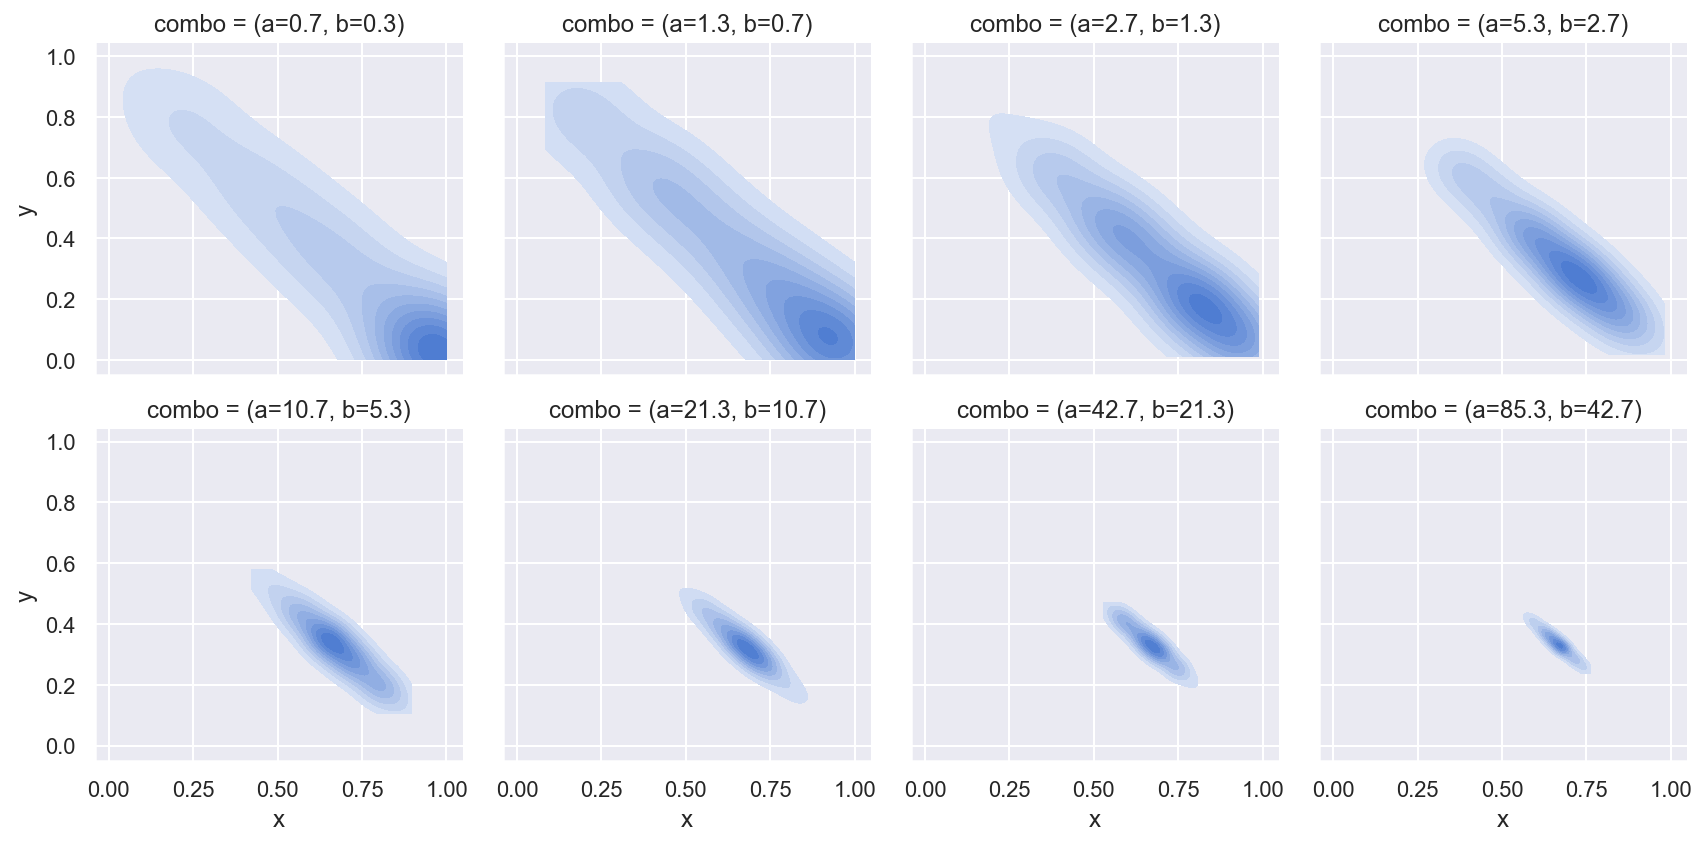

In [192]:
l = []
for a, b in zip(2**np.arange(0, 8, 1) - 2**np.arange(0, 8, 1)/3, 2**np.arange(0, 8, 1)/3):

    # df = pd.DataFrame(np.random.dirichlet(alpha=[a, b], size=100), columns=['x', 'y'])
    df = pd.DataFrame(pm.Dirichlet.dist(a=np.array([a, b])).random(size=100), columns=['x', 'y'])
    df['combo'] = '(a={:.1f}, b={:.1f})'.format(a, b)
    l.append(df)
    
dfp = pd.concat(l, axis=0)    
gd = sns.FacetGrid(col='combo', data=dfp, col_wrap=4)
_ = gd.map(sns.kdeplot, 'x', 'y', shade=True, shade_lowest=False, cut=0)

##### Version history:

version | date | author | changes
:--- | :--- | :--- | :---
0.1 | 2019-11-17 | [jonsedar](https://github.com/jonsedar) | WIP